In [8]:
#라이브러리 설치
! pip install seaborn

Defaulting to user installation because normal site-packages is not writeable
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 294.9/294.9 kB 2.2 MB/s eta 0:00:00a 0:00:01m


# 분석을 위한 모듈 설치

In [9]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import chi2_contingency

# 데이터 로드

In [25]:
df_train = pd.read_csv("train.csv")

# 데이터 기본 정보 파악

In [26]:
# 데이터 총 개수와, 피처 수를 알 수 있다. 또한 어떤 피처에서 결측치가 얼만큼 있는지도 파악할 수 있다. 피처의 자료형도 파악할 수 있다.
# 데이터는 총 59299 개이며, 피처는 총 29개 이다.
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 59299 entries, 0 to 59298
Data columns (total 29 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   bant_submit              59299 non-null  float64
 1   customer_country         58317 non-null  object 
 2   business_unit            59299 non-null  object 
 3   com_reg_ver_win_rate     14568 non-null  float64
 4   customer_idx             59299 non-null  int64  
 5   customer_type            15338 non-null  object 
 6   enterprise               59299 non-null  object 
 7   historical_existing_cnt  13756 non-null  float64
 8   id_strategic_ver         3444 non-null   float64
 9   it_strategic_ver         1121 non-null   float64
 10  idit_strategic_ver       4565 non-null   float64
 11  customer_job             40566 non-null  object 
 12  lead_desc_length         59299 non-null  int64  
 13  inquiry_type             58358 non-null  object 
 14  product_category      

# 수치형과 범주형으로 피처 나누어 저장하기
+ numerical_cols : 수치형 피처들 모음
+ categorical_cols : 범주형 피처들 모음

In [27]:
# 수치형 및 범주형 피처 파악하기
numerical_cols = df_train.select_dtypes(include=['int64','float64']).columns
categorical_cols = df_train.select_dtypes(include=['object']).columns

print(numerical_cols) #수치형 피처
print("============")
print(categorical_cols) #범주형 피처

Index(['bant_submit', 'com_reg_ver_win_rate', 'customer_idx',
       'historical_existing_cnt', 'id_strategic_ver', 'it_strategic_ver',
       'idit_strategic_ver', 'lead_desc_length', 'ver_cus', 'ver_pro',
       'ver_win_rate_x', 'ver_win_ratio_per_bu', 'lead_owner'],
      dtype='object')
Index(['customer_country', 'business_unit', 'customer_type', 'enterprise',
       'customer_job', 'inquiry_type', 'product_category',
       'product_subcategory', 'product_modelname', 'customer_country.1',
       'customer_position', 'response_corporate', 'expected_timeline',
       'business_area', 'business_subarea'],
      dtype='object')


# 피처 별 결측치 수, 비율 확인하기

In [28]:
#피처 별 결측치 수 확인하기
missing_value = df_train.isnull().sum()
print(missing_value)


print("===========")

#피처 별 결측치 비율 계산하기
missing_percent = (missing_value / len(df_train)) * 100
print(missing_percent)

bant_submit                    0
customer_country             982
business_unit                  0
com_reg_ver_win_rate       44731
customer_idx                   0
customer_type              43961
enterprise                     0
historical_existing_cnt    45543
id_strategic_ver           55855
it_strategic_ver           58178
idit_strategic_ver         54734
customer_job               18733
lead_desc_length               0
inquiry_type                 941
product_category           19374
product_subcategory        50064
product_modelname          50070
customer_country.1           982
customer_position              0
response_corporate             0
expected_timeline          30863
ver_cus                        0
ver_pro                        0
ver_win_rate_x             40882
ver_win_ratio_per_bu       43995
business_area              40882
business_subarea           53773
lead_owner                     0
is_converted                   0
dtype: int64
bant_submit                 0.

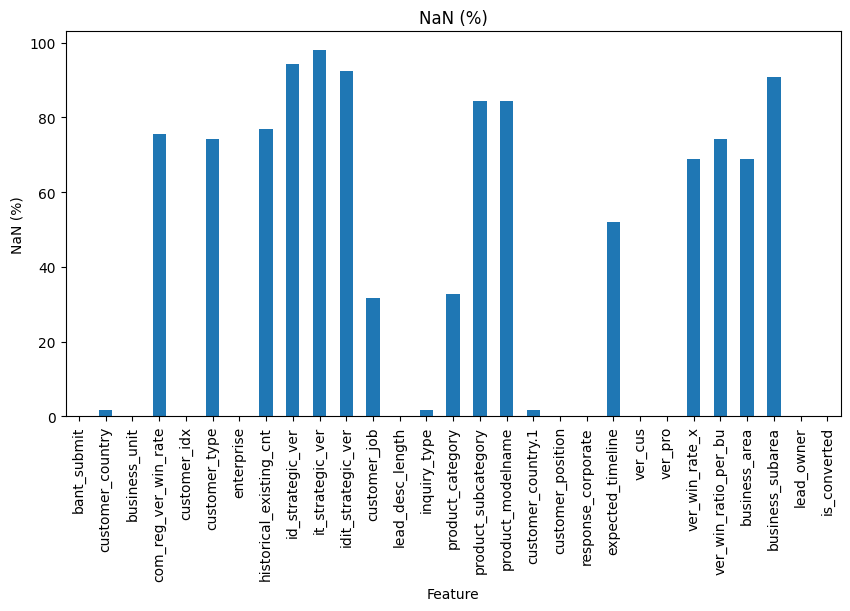

In [29]:
#결측치 비율 그래프로 시각화
plt.figure(figsize=(10, 5))
missing_percent.plot(kind='bar')
plt.title('NaN (%)')
plt.xlabel('Feature')
plt.ylabel('NaN (%)')
plt.show() 

# 피쳐 별 is_converted와의 상관관계 

In [43]:
# is_converted와의 상관관계 출력 (수치형 피처만)
corr_numerical = df_train[numerical_cols].corrwith(df_train['is_converted'])


corr_categorical = {}
for col in categorical_cols:
    
    df_train[col + '_binary'] = df_train[col].apply(lambda x: 1 if x == 'Yes' else 0)
    
    corr, _ = pointbiserialr(df_train[col + '_binary'], df_train['is_converted'])
    corr_categorical[col] = corr

print("Correlation with is_converted (Numerical Features):")
print(corr_numerical)


Correlation with is_converted (Numerical Features):
bant_submit               -0.002480
com_reg_ver_win_rate       0.342590
customer_idx              -0.056425
historical_existing_cnt   -0.004490
id_strategic_ver                NaN
it_strategic_ver                NaN
idit_strategic_ver              NaN
lead_desc_length           0.112822
ver_cus                    0.063554
ver_pro                    0.008846
ver_win_rate_x            -0.048552
ver_win_ratio_per_bu       0.109572
lead_owner                 0.098862
dtype: float64


In [45]:
#is_converted와의 상관관계 (범주형)

# 범주형 피처와 is_converted 사이의 연관성 분석을 위해 먼저, is_converted를 정수로 변환(True=1, False=0)
df_train['is_converted_int'] = df_train['is_converted'].astype(int)


# 각 범주형 피처 에 대해 카이제곱 test를 수행하여 연관성 파악

chi2_results = {}

for feature in categorical_cols:
    
    contingency_table = pd.crosstab(df_train[feature], df_train['is_converted_int'])
    
    chi2, p, dof, expected = chi2_contingency(contingency_table)
    chi2_results[feature] = {'chi2': chi2, 'p-value': p}


#data frame형태로 출력
chi2_results_df = pd.DataFrame(chi2_results).transpose()

chi2_results_df


,chi2,p-value
customer_country,23591.337816,0.000000e+00
business_unit,416.865527,6.307330e-89
customer_type,355.677400,2.738764e-56
enterprise,924.723348,4.143259e-203
customer_job,850.680374,1.915485e-14
inquiry_type,569.656188,2.194603e-79
product_category,2602.030723,0.000000e+00
product_subcategory,647.307114,5.382247e-23
product_modelname,1389.711928,1.600482e-53
customer_country.1,23591.337816,0.000000e+00


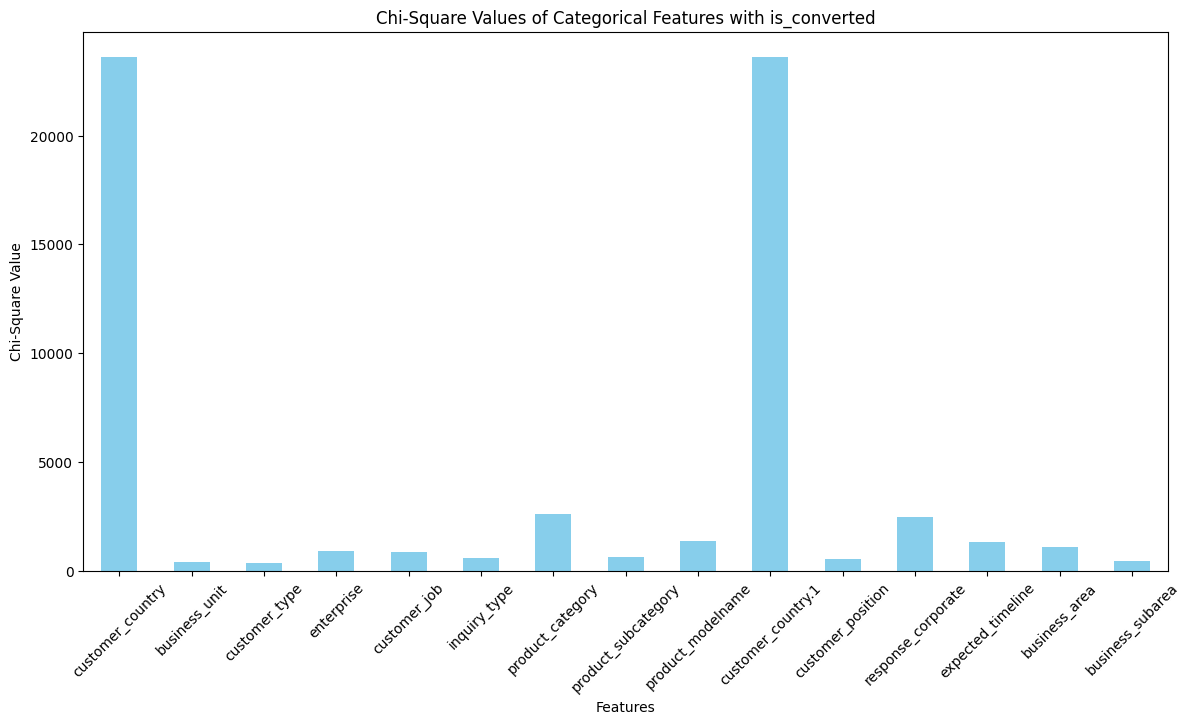

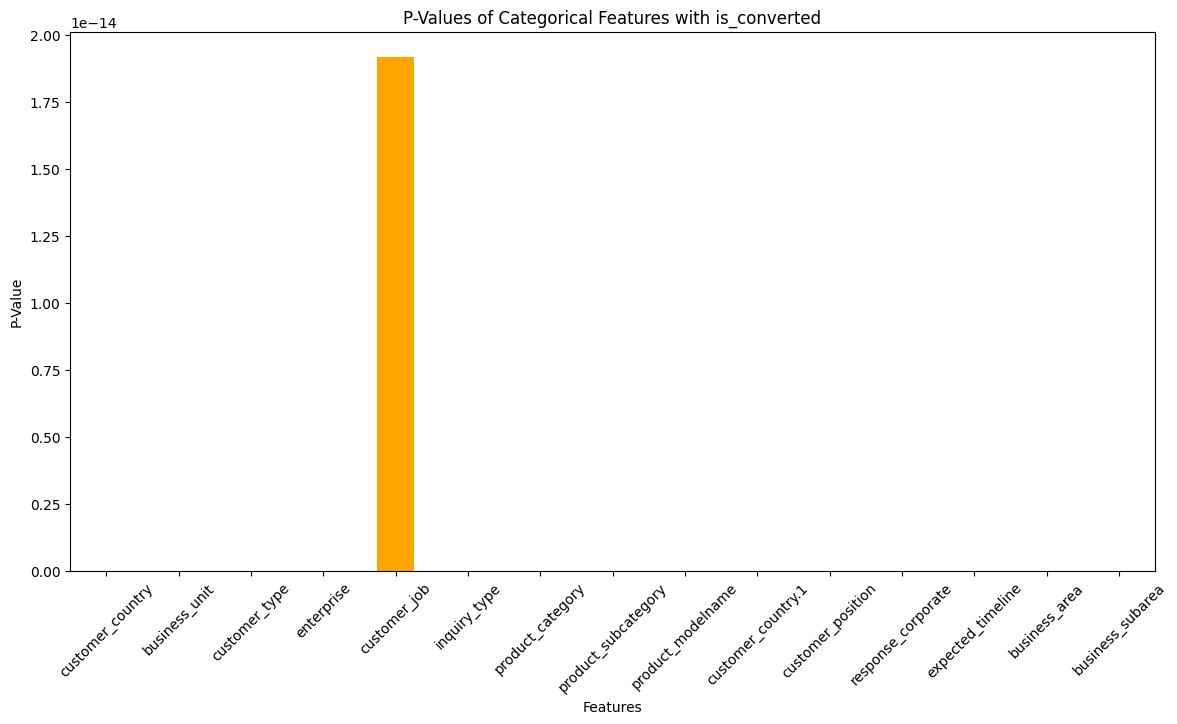

In [51]:
#위 코드 시각화

# chi2 값에 기반한 그래프 시각화
chi2_results_df['chi2'].plot(kind='bar', figsize=(14, 7), color='skyblue')
plt.title('Chi-Square Values of Categorical Features with is_converted')
plt.xlabel('Features')
plt.ylabel('Chi-Square Value')
plt.xticks(rotation=45)
plt.show()

# p-value에 기반한 그래프 시각화
chi2_results_df['p-value'].plot(kind='bar', figsize=(14, 7), color='orange')
plt.title('P-Values of Categorical Features with is_converted')
plt.xlabel('Features')
plt.ylabel('P-Value')
plt.xticks(rotation=45)
plt.show()


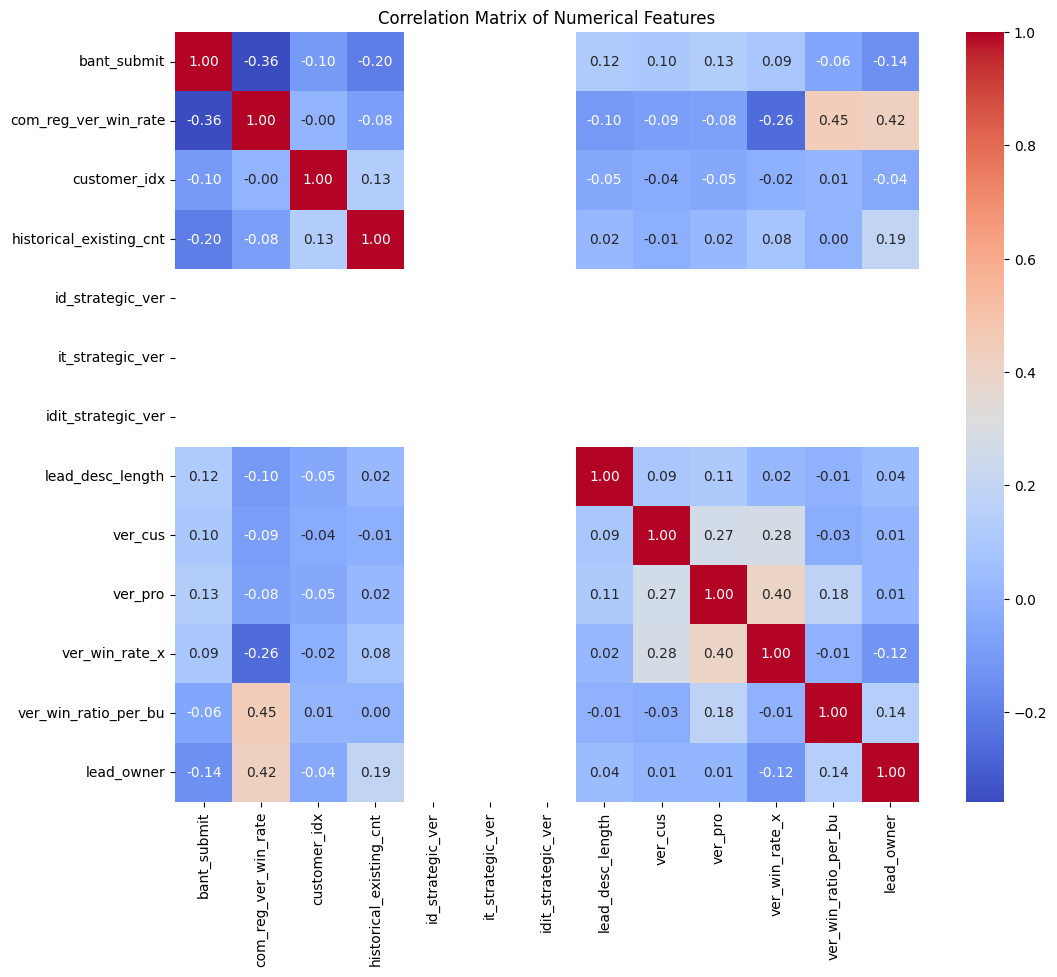

In [52]:
# 수치형 피처들간 상관 관계 매트릭스 생성

correlation_matrix = df_train[numerical_cols].corr()

# 상관 관계 매트릭스를 히트맵으로 시각화
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap='coolwarm')
plt.title('Correlation Matrix of Numerical Features')
plt.show()


In [53]:
# 'customer_country'와 'customer_country.1'이 두 피처 데이터가 서로 동일한가? 98퍼 동일
# 먼저 이 두 특성 간의 일치 여부를 확인합니다.

# 'customer_country'와 'customer_country.1'이 동일한지 여부를 나타내는 새로운 컬럼 생성
df_train['country_match'] = df_train['customer_country'] == df_train['customer_country.1']

# 'country_match'의 분포 확인
country_match_distribution = df_train['country_match'].value_counts(normalize=True)

country_match_distribution


country_match
True     0.98344
False    0.01656
Name: proportion, dtype: float64

# 하나의 피처가 가진 변수 종류를 시각화 ( 또 다른 피처 넣어서 시각화 가능)

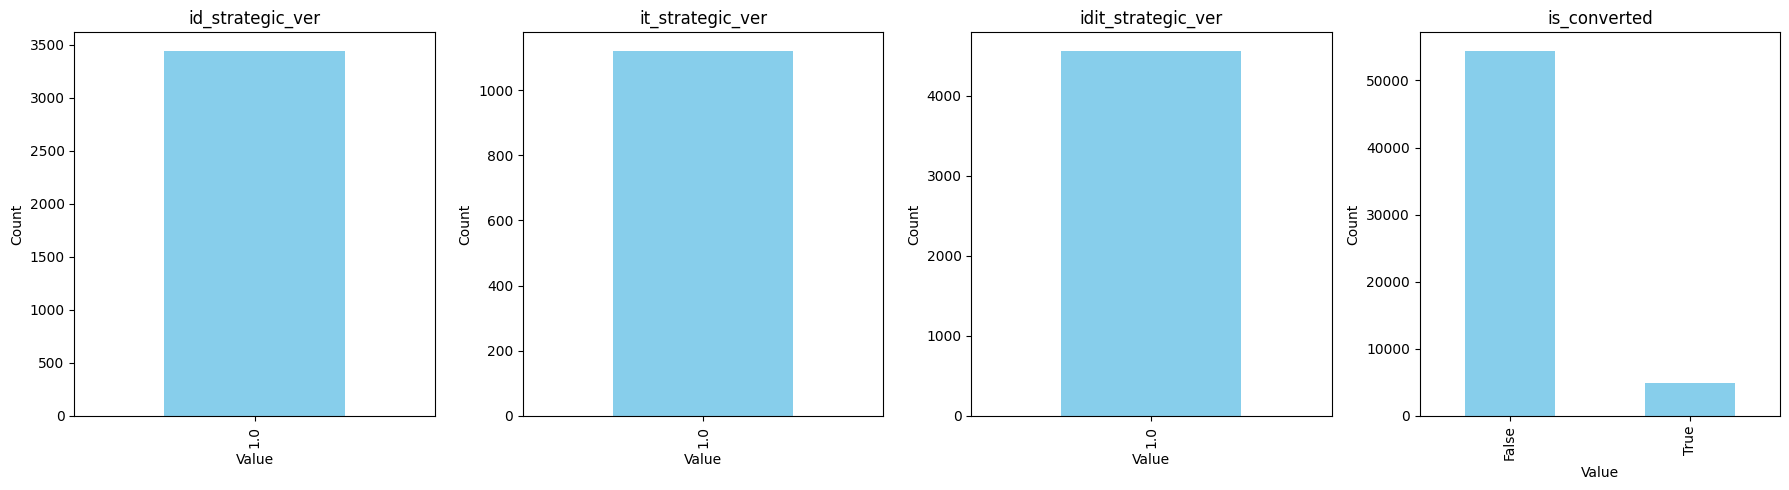

In [58]:
# 'id_strategic_ver', 'it_strategic_ver', 'idit_strategic_ver'의 값 분포를 시각화하여
# 이 특성들이 실제로 구분할 수 없는지 확인합니다.


# 각 피처의 unique value와 그 개수를 시각화
fig, axs = plt.subplots(1, 4, figsize=(18, 5))

# 각 피처에 대해 바 차트 생성
features = ['id_strategic_ver', 'it_strategic_ver', 'idit_strategic_ver', 'is_converted']
for i, feature in enumerate(features):
    df_train[feature].value_counts().plot(kind='bar', ax=axs[i], color='skyblue')
    axs[i].set_title(feature)
    axs[i].set_xlabel('Value')
    axs[i].set_ylabel('Count')

plt.tight_layout()
plt.show()


# 이상치 알아보기 

In [60]:
#IQR 방식 사용 , 수치형 피처들에 대해서만


outliers = {}
for feature in numerical_cols:
    Q1 = df_train[feature].quantile(0.25)
    Q3 = df_train[feature].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    

    outliers_count = df_train[(df_train[feature] < lower_bound) | (df_train[feature] > upper_bound)][feature].count()
    outliers[feature] = outliers_count

# 이상치 개수를 DataFrame으로 변환하여 출력
outliers_df = pd.DataFrame(list(outliers.items()), columns=['Feature', 'Outliers Count']).sort_values(by='Outliers Count', ascending=False)
outliers_df


,Feature,Outliers Count
7,lead_desc_length,5558
10,ver_win_rate_x,4097
9,ver_pro,3013
12,lead_owner,2710
8,ver_cus,2467
3,historical_existing_cnt,1676
1,com_reg_ver_win_rate,1340
11,ver_win_ratio_per_bu,409
0,bant_submit,0
2,customer_idx,0
